# Marginal Gaussianization

* Author: J. Emmanuel Johnson
* Email: jemanjohnson34@gmail.com

In this demonstration, we will show how we can do the marginal Gaussianization on a 2D dataset using the Histogram transformation and Inverse CDF Gaussian distribution. 



In [1]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

from rbig.data import ToyData
from rbig.transform.gaussianization import HistogramGaussianization

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

## Data

For this example, we are looking at a 2D dataset.

In [2]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

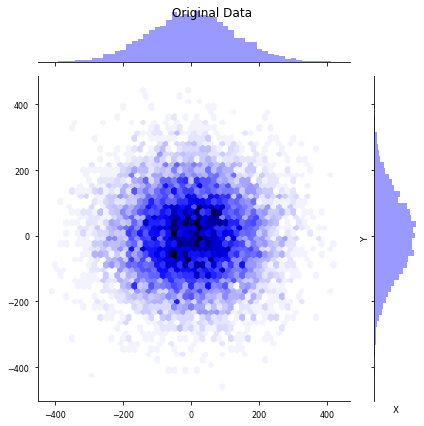

In [3]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'moons'
n_samples = 10_000
noise = 0.1
random_state=123


data = ToyData(dataset, n_samples, noise, random_state).generate_samples()
X = data[:, 0]
Y = data[:, 1]

plot_2d_joint(data, title='Original Data')

## Marginal Histogram Transformation

So, for this transformation, we are going to transform our data from the current distribution to a marginally Gaussian distribution and then perform a rotation. In theory, if we do enough of these, we will eventually convert to a Gaussian distribution.

In [4]:
# parameters
nbins = 1_000   # number of bins to do the histogram transform
alpha = 1e-05   # adds some regularization (noise)

# initialize the transformer
mg_transformer = HistogramGaussianization(
    nbins=nbins,
    alpha=alpha
)

# fit the transformer to the data
mg_transformer.fit(data);

### 1. Forward Transformation

For this transformation, we will be applying the following:

$$\Psi(\mathbf{x}) = \Phi^{-1}(\mathbf{x})$$

where $\Phi^{-1}(\cdot)$ is the inverse CDF of the Gaussian distribution.

<Figure size 360x360 with 0 Axes>

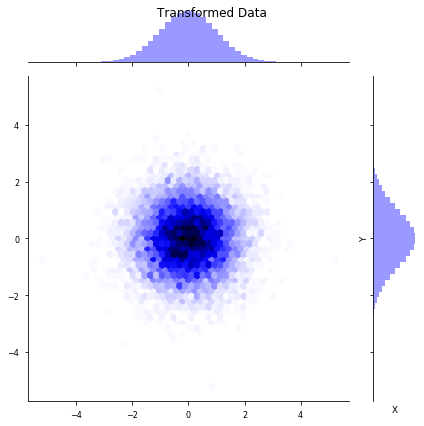

In [5]:
data_trans = mg_transformer.transform(data)

plot_2d_joint(data_trans, title='Transformed Data')

So clearly we can see that the transformation works. Both of the marginals are Gaussian distributed..

### 2. Inverse Transformation

For this step, we will apply the inverse transformation:

$$\Psi^{-1}(\mathbf{x}) = \Phi \left( \mathbf{x} \right)$$

where $\Phi(\cdot)$ is the CDF of the Gaussian distribution.

In [6]:
data_approx = mg_transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_approx, data, decimal=1e-5)

We see that this transformation is very close to the original. In fact, it's close to approximately 1e-5 decimal places. The errors will definitely stem from the boundaries.

<Figure size 360x360 with 0 Axes>

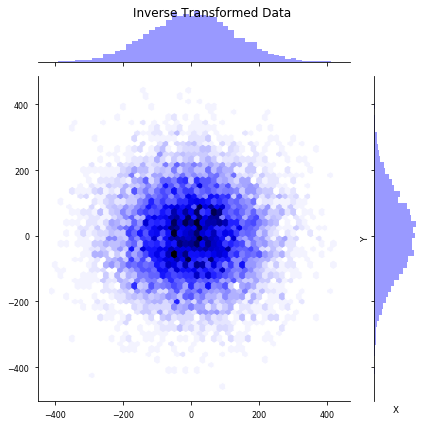

In [7]:
# Plot results
plot_2d_joint(data_approx, title='Inverse Transformed Data')

## Log Absolute Determinant Jacobian

Using the derivative of inverse-functions theorem, we can calculate the derivative like so:

$$\nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = \frac{1}{\phi (\Phi^{-1} (x)) }$$

where $\phi(\cdot)$ is the PDF of the Gaussian distribution. Taking the log of these terms gives us:

$$ \log \nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = - \log \phi (\Phi^{-1} (x))$$



In [10]:
data_mg_der.min(), data_mg_der.max()

(-inf, 5.404773027656704)

In [11]:
np.exp(data_mg_der).min(), np.exp(data_mg_der).max()

(0.0, 222.4657211870199)

/home/emmanuel/.conda/envs/rbig_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


OverflowError: cannot convert float infinity to integer

<Figure size 360x360 with 0 Axes>

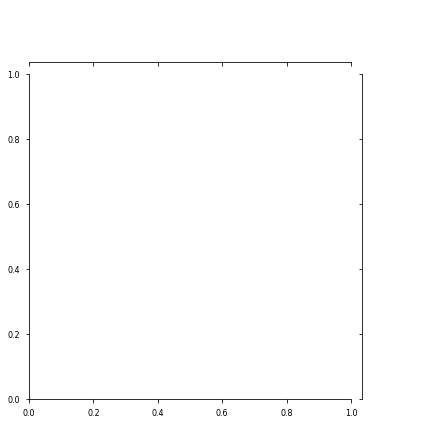

In [9]:
data_mg_der = mg_transformer.log_abs_det_jacobian(data)

# plot the gradients
plot_2d_joint(data_mg_der, title='Jacobian Data')

## Log Probability

$$\log p_\theta(\mathbf{x}) = \log p_\theta \left( \mathbf{z} \right) + \log \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$


In [12]:
# score samples 
log_prob = mg_transformer.score_samples(data)

/home/emmanuel/.conda/envs/rbig_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


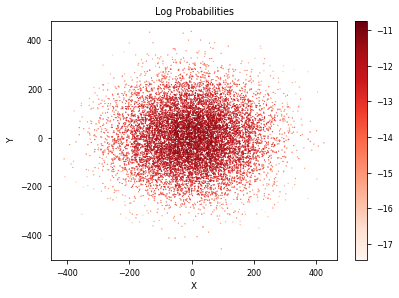

In [13]:
plot_prob(data, log_prob, title='Log Probabilities')

## Probability

This is the same as above but without the log scale:

$$p_\theta(\mathbf{x}) = p_\theta \left( \mathbf{z} \right) \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$

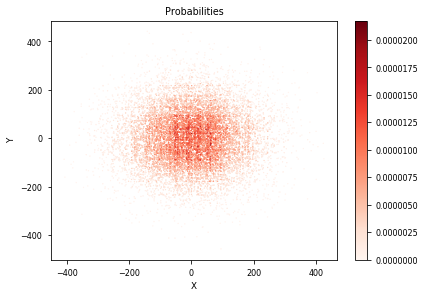

In [14]:
plot_prob(data, np.exp(log_prob), title='Probabilities')

## Negative Log-Likelihood

We need to take the expected value (mean) of all log probabilities.

$$\text{nll} = \frac{1}{N} \sum_{n=1}^{N} \log p_\theta(\mathbf{x})$$

In [15]:
score = mg_transformer.score(data)

print(f"Negative Log-Likelihood Score: {score:.4f}")

Negative Log-Likelihood Score: -inf


/home/emmanuel/.conda/envs/rbig_dev/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
